# Multi-class Classification & Neural Networks

## Multi-class Classifier

In [190]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat # To load .mat files.
from scipy.special import expit 
%matplotlib inline

#### Data
There are 5000 images, each represented by a 20 pixel by 20 pixel matrix unrolled in to a vector of 400 elements.
Since the datafile was in matlab native format the zero digit was mapped to 10. We will remap it back to zero here.

In [14]:
datafile = os.path.join('data', 'ex3data1.mat')
data = loadmat(datafile)
X, y = data.get('X'), data.get('y')
y[y==10] = 0

In [132]:
m, n = X.shape
k, l = y.shape

In [133]:
m, n, k, l

(5000, 400, 5000, 1)

In [155]:
# It will be better to have the shape of y be (k, ), 
# since then we will be able to use the codes from the 
# previous exercise without modification.

# Note to self: It is generally a good idea to check 
# the dimensions of the data at the beginning.

y = y.flatten()

#### Visualization of data

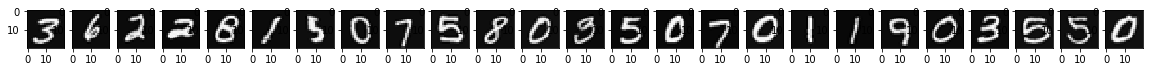

In [46]:
nrows = 25

def row_to_square(X_row):
    return np.reshape(X_row, (20, 20)).T

# Choose nrows random rows of X.
indices = np.random.randint(m, size=nrows)
X_sel = X[indices, :]

fig, ax = plt.subplots(1, nrows, figsize=(20, 20))

for i in range(nrows):
    ax[i].imshow(row_to_square(X_sel[i, :]), cmap='gray')

### Cost function and gradient
 We will always use the regularized cost function and its gradient. They will reduce to the non-regularized versions when the regulator is 0.

In [203]:
def cost_function(theta, x, y, regulator=0):
    m = y.size
    hypothesis = expit(np.dot(x, theta))
    term1 = -y * np.log(hypothesis)
    term2 = -(1 - y) * np.log(1 - hypothesis)
    cost = np.sum(term1 + term2) / m
    theta2 = regulator * np.sum(theta ** 2) / (2*m)
    return cost + theta2

def gradient(theta, x, y, regulator=0):
    m, n = x.shape
    hypothesis = expit(np.dot(x, theta))
    grad = (1. / m) * np.sum((hypothesis - y)[:, None] * x, axis=0)
    reg_theta = np.ones(n) * regulator / m
    reg_grad = grad + reg_theta
    reg_grad[0] = grad[0]
    return reg_grad

### One vs All classifier

In [195]:
def optimize_theta(theta, x, y, regulator=0):
    result = minimize(cost_function, theta, 
                      args=(x, y, regulator), jac=gradient,
                      method='CG', options={"maxiter":400})
    return result.x

def compute_theta(x, y, num_labels, regulator=0):
    m, n = x.shape
    x = np.insert(x, 0, 1, axis=1)
    initial_theta = np.zeros(n+1)
    all_theta = np.zeros((n+1, num_labels))
    for label in np.arange(num_labels):
        outcome = (y == label).astype(int)
        all_theta[:, label] = optimize_theta(initial_theta, x, outcome, regulator)
    return all_theta

In [196]:
num_labels = np.unique(y).size
regulator = 0.1
theta = compute_theta(X, y, num_labels, regulator)

In [199]:
theta.shape

(401, 10)

### Prediction

In [200]:
def predict_one_v_all(theta, x):
    x = np.insert(x, 0, 1, axis=1)
    prbbls = np.dot(x, theta)
    return np.argmax(prbbls, axis=1)

In [201]:
predictions = predict_one_v_all(theta, X)

In [202]:
np.mean(predictions == y)

0.9644

Thus the classifier predicts the training data with 96% accuracy.

## Neural Networks

Classify the same data using a pretrained neural network. The network has three layers, with one hidden. The hidden layer has 25 units and the output layer has 10 units, corresponding to the ten digits.

In [208]:
input_layer_size = 400 # Each image consists of 20 x 20 pixels
hidden_layer_size = 25
num_labels = 10

weightsfile = os.path.join('data', 'ex3weights.mat')
weights = loadmat(weightsfile)

theta1 = weights.get('Theta1')
theta2 = weights.get('Theta2')
theta2 = np.roll(theta2, 1, axis=0) # From matlab indexing to python indexing

In [205]:
theta1.shape

(25, 401)

In [206]:
theta2.shape

(10, 26)

### Prediction

In [223]:
def predict_nn(theta1, theta2, x):
    # Ensure that x is two-dimensional.
    if x.ndim == 1:
        x = x[None]
    a1 = np.insert(x, 0, 1, axis=1)
    z2 = np.dot(theta1, a1.T)
    a2 = expit(z2)
    a2 = np.insert(a2, 0, 1, axis=0)
    z3 = np.dot(theta2, a2)
    a3 = expit(z3.T)
    return np.argmax(a3, axis=1)

In [224]:
np.mean(predict_nn(theta1, theta2, X) == y)

0.9752

Thus the network predicts the data with 97.5% accuracy.

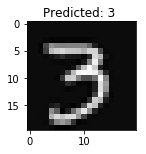

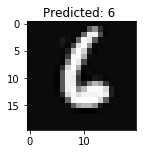

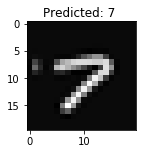

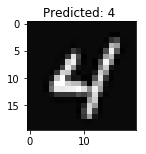

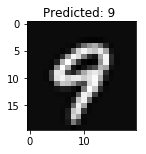

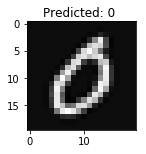

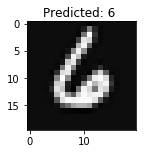

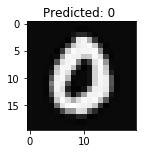

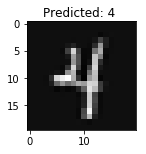

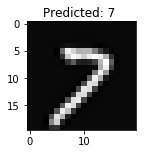

In [228]:
indices = np.random.randint(m, size=10)

for index in indices:
    fig = plt.figure(figsize=(2, 2))
    predicted_value = predict_nn(theta1, theta2, X[index, :])
    plt.imshow(row_to_square(X[index, :]), cmap='gray')
    fig.suptitle('Predicted: %d' %predicted_value)